In [1]:
import os

from transformers import Wav2Vec2Model
import torch.nn as nn
from pydub import AudioSegment
import torch
from torch.utils.data import DataLoader
import pandas as pd


/Users/roeeseren/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [58]:
# Local imports
import data_utils
import importlib
importlib.reload(data_utils)
from data_utils import get_data
from utils import load_protocol, plot_results
import train_utils
import audio_utils
from models.wav2vec_modified import Wav2Vec2BinaryClassifier

In [3]:
dataset_path = get_data()

train_dir = f"{dataset_path}/LA/LA/ASVspoof2019_LA_train/flac"
val_dir = f"{dataset_path}/LA/LA/ASVspoof2019_LA_dev/flac"
test_dir = f"{dataset_path}/LA/LA/ASVspoof2019_LA_eval/flac"

In [48]:
col_names = ['speaker', 'file_name', 'attack', 'label']
protocols_folder = "LA/LA/ASVspoof2019_LA_cm_protocols"
protocol_file_prefix = "ASVspoof2019.LA.cm"

data_info_train_file_path = f"{dataset_path}/{protocols_folder}/{protocol_file_prefix}.train.trn.txt"
data_info_val_file_path = f"{dataset_path}/{protocols_folder}/{protocol_file_prefix}.dev.trl.txt"
data_info_test_file_path = f"{dataset_path}/{protocols_folder}/{protocol_file_prefix}.eval.trl.txt"

train_df_info = load_protocol(data_info_train_file_path, names=col_names)
val_df_info = load_protocol(data_info_val_file_path, names=col_names)
test_df_info = load_protocol(data_info_test_file_path, names=col_names)

In [8]:
# Balance data - get equal number of data files for each label
bonafide_rows = train_df_info[train_df_info['label'] == 'bonafide']
spoof_rows = train_df_info[train_df_info['label'] == 'spoof'].sample(n=len(bonafide_rows))

train_df_info = pd.concat([bonafide_rows, spoof_rows], ignore_index=True)

In [10]:
train_df_info['label'].value_counts()

label
bonafide    2580
spoof       2580
Name: count, dtype: int64

In [11]:
# Add augmentations to train data
train_df_info = audio_utils.add_augmentations(train_dir, train_df_info)

In [12]:
train_df_info['label'].value_counts()

label
bonafide    3231
spoof       3219
Name: count, dtype: int64

In [13]:
# get a file that was augmented
train_augmented_files = [f for f in os.listdir(train_dir) if f.startswith("aug_")]

example_aug_file = train_augmented_files[2]
example_orig_file = example_aug_file[4:]



In [14]:
# display original file
AudioSegment.from_file(f"{train_dir}/{example_orig_file}", format="flac")

In [15]:
# display augmentation file
AudioSegment.from_file(f"{train_dir}/{example_aug_file}", format="flac")

In [49]:
train_df = data_utils.process_data_frame(train_dir, train_df_info)
val_df = data_utils.process_data_frame(val_dir, val_df_info)
test_df = data_utils.process_data_frame(test_dir, test_df_info)

      file_name label
0  LA_E_2834763     1
1  LA_E_8877452     1
2  LA_E_6828287     1
3  LA_E_6977360     1
4  LA_E_5932896     1


In [17]:
train_df[train_df['file_name'] == example_aug_file[:-5]]

,file_name,label
5325,aug_LA_T_9854555,1


In [36]:
val_df['label'].value_counts()

label
1    22296
0     2548
Name: count, dtype: int64

In [37]:
# Reduce validation set significantly, and balance data for each label
val_bonafide_rows = val_df[val_df['label'] == 0]
val_bonafide_rows = val_bonafide_rows.sample(n=int(len(val_bonafide_rows) * 0.3))
val_spoof_rows = val_df[val_df['label'] == 1].sample(n=len(val_bonafide_rows))

val_df = pd.concat([val_bonafide_rows, val_spoof_rows], ignore_index=True)

In [40]:
val_df['label'].value_counts()

label
0    764
1    764
Name: count, dtype: int64

In [51]:
train_dataset = audio_utils.AudioDataset(data_dir=train_dir, df=train_df)
val_dataset = audio_utils.AudioDataset(data_dir=val_dir, df=val_df)
test_dataset = audio_utils.AudioDataset(data_dir=test_dir, df=test_df)

In [28]:
device = torch.device('mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device chosen: {device}")

Device chosen: mps


In [29]:
def freeze_except_classifier(model):
    """
    Freeze all layers of the Wav2Vec 2.0 model except the classifier layers.
    """
    
    # Freeze all parameters in the Wav2Vec 2.0 model
    for param in model.wav2vec2.parameters():
        param.requires_grad = False

    # Unfreeze the classifier layers
    for param in model.classifier.parameters():
        param.requires_grad = True

    print("Wav2Vec 2.0 layers frozen. Only classifier layers are trainable.")

In [30]:
# Hyperparameters
LEARNING_RATE = 0.001
criterion = nn.BCEWithLogitsLoss()
EPOCHS = 5
BATCH_SIZE = 16

In [42]:
wav2vec = Wav2Vec2BinaryClassifier()
freeze_except_classifier(wav2vec)

optimizer = torch.optim.Adam(wav2vec.parameters(), lr=LEARNING_RATE)
wav2vec.to(device)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

results = train_utils.train_model(wav2vec, train_loader, val_loader, criterion, optimizer, EPOCHS, device) 

/Library/Python/3.9/site-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Wav2Vec 2.0 layers frozen. Only classifier layers are trainable.
Progress of epoch 1/5: loop 0/404 finished
Progress of epoch 1/5: loop 50/404 finished
Progress of epoch 1/5: loop 100/404 finished
Progress of epoch 1/5: loop 150/404 finished
Progress of epoch 1/5: loop 200/404 finished
Progress of epoch 1/5: loop 250/404 finished
Progress of epoch 1/5: loop 300/404 finished
Progress of epoch 1/5: loop 350/404 finished
Progress of epoch 1/5: loop 400/404 finished
Epoch [1/5], Loss: 0.5960, Train Accuracy: 79.29%, Val Accuracy: 0.77%
Progress of epoch 2/5: loop 0/404 finished
Progress of epoch 2/5: loop 50/404 finished
Progress of epoch 2/5: loop 100/404 finished
Progress of epoch 2/5: loop 150/404 finished
Progress of epoch 2/5: loop 200/404 finished
Progress of epoch 2/5: loop 250/404 finished
Progress of epoch 2/5: loop 300/404 finished
Progress of epoch 2/5: loop 350/404 finished
Progress of epoch 2/5: loop 400/404 finished
Epoch [2/5], Loss: 0.5641, Train Accuracy: 85.88%, Val Accur

In [44]:
last_val_accuracy, best_val, history = results

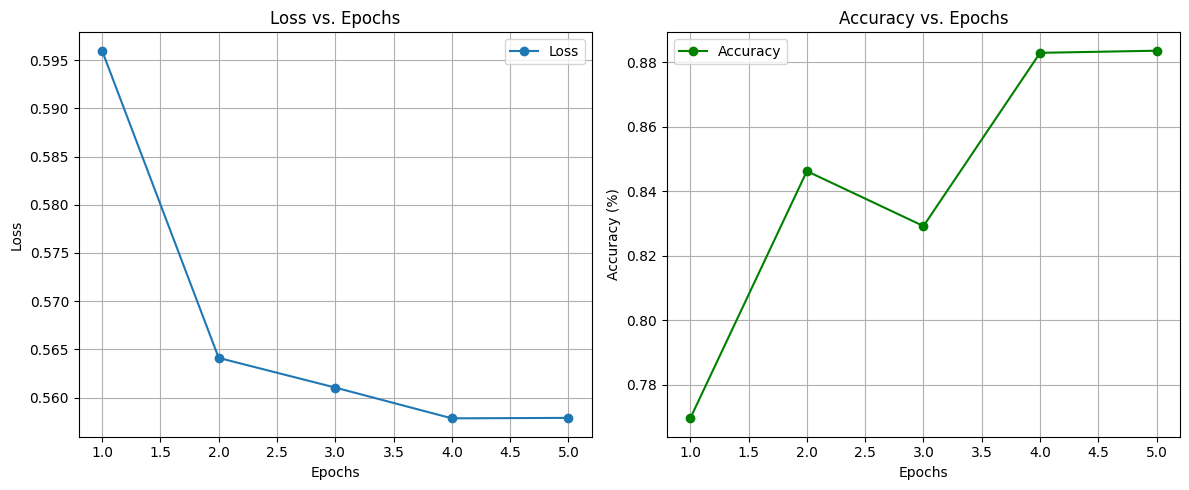

In [46]:
plot_results(history['train_loss'], history['val_accuracy'], 5)

In [52]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_data = train_utils.evaluate_model(wav2vec, test_loader, criterion, device)

In [53]:
test_data

{'loss': 0.46496097966041455,
 'accuracy': 0.7000294790628465,
 'precision': 0.9988032382963745,
 'recall': 0.6662909739832816,
 'f1': 0.7993464604636751,
 'eer': 0.25151893439184386}

In [54]:
torch.save(wav2vec.state_dict(), "trained_models/wav2vec_model_weights.pth")